,1m_timestamp,1m_open,1m_high,1m_low,1m_close,1m_volume,1m_RSI_ST,1m_RSI_LOG,1m_MACD,1m_MACD_ST,...,5m_close_to_4h_support,5m_close_to_4h_resistance,15m_close_to_4h_support,15m_close_to_4h_resistance,30m_close_to_4h_support,30m_close_to_4h_resistance,1h_close_to_4h_support,1h_close_to_4h_resistance,4h_close_to_1d_support,4h_close_to_1d_resistance
0,1627755600000,41306.41,41350.00,41306.41,41335.68,0.002180,0.001666,4.232088,31.000378,0.000750,...,-0.151384,-0.161240,-0.194374,-0.203731,-0.192330,-0.201710,-0.110163,-0.120498,0.137525,0.105198
1,1627755720000,41344.84,41384.23,41344.84,41384.23,0.145714,0.001771,4.294400,38.847941,0.000939,...,-0.153821,-0.163737,-0.193097,-0.202553,-0.193076,-0.202532,-0.124335,-0.134597,0.248866,0.105659
2,1627755780000,41384.23,41384.23,41377.79,41377.81,0.001080,0.001736,4.274355,44.041468,0.001064,...,-0.152962,-0.173681,-0.193573,-0.213298,-0.193573,-0.213298,-0.116651,-0.138257,0.271643,0.125825
3,1627755840000,41377.81,41416.00,41377.81,41407.93,0.051798,0.001797,4.309464,50.011308,0.001208,...,-0.152015,-0.181302,-0.195155,-0.222953,-0.191090,-0.219028,-0.116188,-0.146713,0.330763,0.135231
4,1627755900000,41407.93,41407.93,41388.26,41389.59,0.001933,0.001696,4.251423,52.655585,0.001272,...,-0.151435,-0.180743,-0.193347,-0.221208,-0.190705,-0.218656,-0.114332,-0.144921,0.373425,0.134284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,1627782120000,41738.84,41742.53,41729.53,41729.53,0.002922,0.001149,3.869792,-8.267611,-0.000198,...,-0.376296,-0.413828,-0.306785,-0.348500,-0.233217,-0.279360,-0.242827,-0.288391,1.383696,1.071975
440,1627782180000,41729.53,41757.17,41729.53,41749.99,0.003104,0.001217,3.927685,-6.509114,-0.000156,...,-0.378049,-0.415476,-0.306335,-0.348078,-0.235832,-0.281818,-0.239014,-0.284808,1.381661,1.098594
441,1627782240000,41749.99,41756.14,41748.64,41748.64,0.000781,0.001212,3.923794,-5.164888,-0.000124,...,-0.377268,-0.414742,-0.304461,-0.346317,-0.235287,-0.281306,-0.238435,-0.284264,1.357635,1.080890
442,1627782300000,41748.64,41771.57,41747.63,41771.57,0.006708,0.001290,3.986558,-2.223687,-0.000053,...,-0.359810,-0.416172,-0.282851,-0.345988,-0.213325,-0.282583,-0.216893,-0.285837,1.258910,0.998269


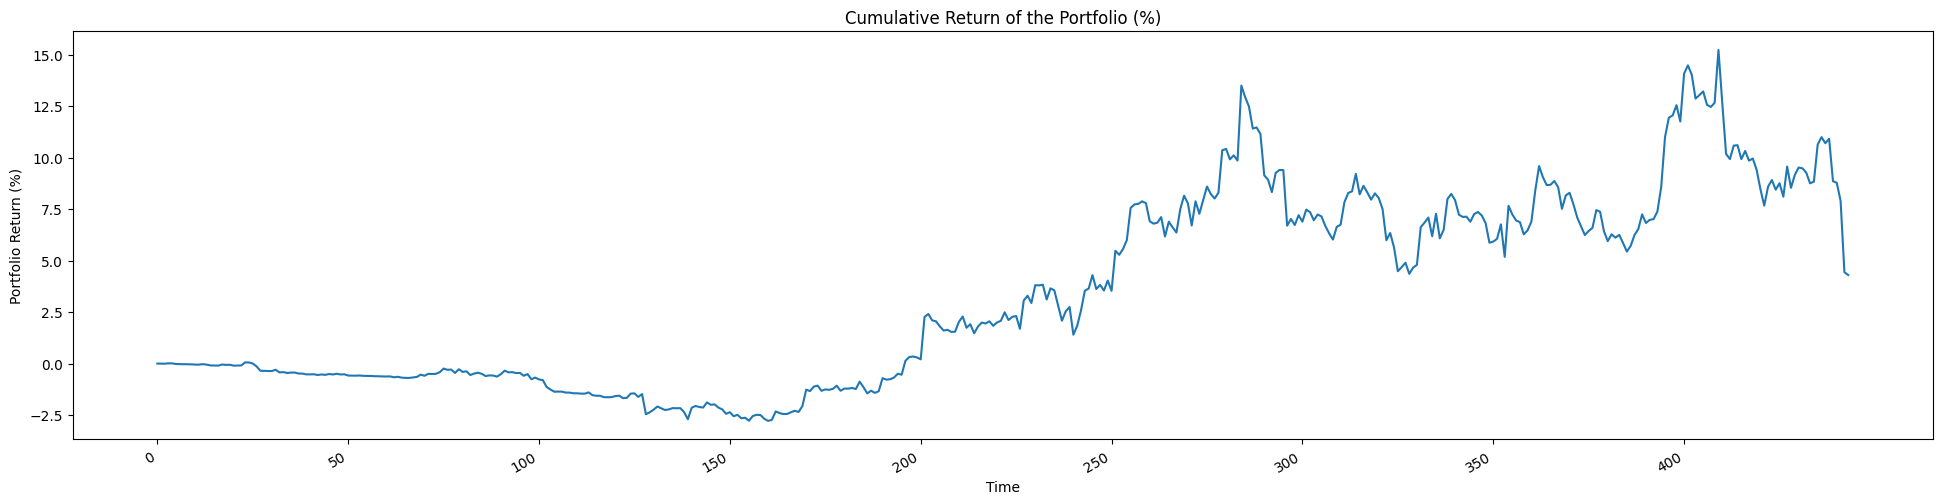

Cumulative return amount: 429.59354345000247
Asset growth rate: 4.29593543450002%


In [29]:
import os
import pandas as pd
import numpy as np
import talib
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.dates as mdates
import datetime

def load_data(file_names):
    dfs = []
    for file_name in file_names:
        df = pd.read_csv(file_name)
        dfs.append(df)
    return dfs

def feature_engineering(df, prefix):
    open = df[f'{prefix}_open'].values
    high = df[f'{prefix}_high'].values
    low = df[f'{prefix}_low'].values
    close = df[f'{prefix}_close'].values
    volume = df[f'{prefix}_volume'].values
    hilo = (high + low) / 2

    df[f'{prefix}_RSI_ST'] = talib.RSI(close)/close
    df[f'{prefix}_RSI_LOG'] = log_transform_feature(talib.RSI(close))
    df[f'{prefix}_MACD'], _, _ = talib.MACD(close)
    df[f'{prefix}_MACD_ST'], _, _ = talib.MACD(close)/close
    df[f'{prefix}_ATR'] = talib.ATR(high, low, close)
    df[f'{prefix}_ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df[f'{prefix}_ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    
    df[f'{prefix}_SMA10'] = talib.SMA(close, timeperiod=10)
    df[f'{prefix}_SMA50'] = talib.SMA(close, timeperiod=50)
    df[f'{prefix}_SMA200'] = talib.SMA(close, timeperiod=200)
    
    df[f'{prefix}_BB_UPPER'], df[f'{prefix}_BB_MIDDLE'], df[f'{prefix}_BB_LOWER'] = talib.BBANDS(close)
    df[f'{prefix}_BBANDS_upperband'] = (df[f'{prefix}_BB_UPPER'] - hilo) / close
    df[f'{prefix}_BBANDS_middleband'] = (df[f'{prefix}_BB_MIDDLE'] - hilo) / close
    df[f'{prefix}_BBANDS_lowerband'] = (df[f'{prefix}_BB_LOWER'] - hilo) / close
    df[f'{prefix}_STOCH_K'], df[f'{prefix}_STOCH_D'] = talib.STOCH(high, low, close)/close
    df[f'{prefix}_MON'] = talib.MOM(close, timeperiod=5)
    df[f'{prefix}_OBV'] = talib.OBV(close, volume)

    # Calculate high_close_comparison
    df[f'{prefix}_High_Close_Comparison'] = calculate_high_close_comparison(df, prefix)
    df[f'{prefix}_consecutive_up'], df[f'{prefix}_consecutive_down']  = calculate_consecutive_candles(df, prefix)
    df[f'{prefix}_double_top'], df[f'{prefix}_double_bottom'] = detect_double_top_bottom(df, prefix)

    df = detect_triangle_pattern(df, prefix)
    df = parallel_channel(df, prefix)
    df = add_additional_features(df, prefix)

    df = df.dropna()
    df = df.reset_index(drop=True)

    return df

def add_additional_features(df, prefix):
    close = df[f'{prefix}_close'].values
    df[f'{prefix}_PPO'] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
    df[f'{prefix}_perc_from_high'] = (df[f'{prefix}_high'].rolling(window=14).max() - close) / close
    df[f'{prefix}_perc_from_low'] = (close - df[f'{prefix}_low'].rolling(window=14).min()) / close    
    df[f'{prefix}_Range'] = df[f'{prefix}_high'] - df[f'{prefix}_low']
    return df

def log_transform_feature(X):
    X[X <= 0] = np.finfo(float).eps
    return np.log(X)

def support_resistance(df, prefix, window=20):
    high = df[f'{prefix}_high']
    low = df[f'{prefix}_low']
    close = df[f'{prefix}_close']
    df[f'{prefix}_support'] = low.rolling(window=window, min_periods=1).min()
    df[f'{prefix}_resistance'] = high.rolling(window=window, min_periods=1).max()
    return df

def price_relation(df, short_prefix, long_prefix):
    short_close = df[f'{short_prefix}_close']
    long_support = df[f'{long_prefix}_support']
    long_resistance = df[f'{long_prefix}_resistance']
    df[f'{short_prefix}_close_to_{long_prefix}_support'] = (short_close - long_support) / long_support
    df[f'{short_prefix}_close_to_{long_prefix}_resistance'] = (short_close - long_resistance) / long_resistance
    return df

def calculate_high_close_comparison(df, prefix):
    high = df[f'{prefix}_high'].values
    close = df[f'{prefix}_close'].values
    higher_high = np.zeros(len(high), dtype=int)
    higher_close = np.zeros(len(close), dtype=int)
    higher_high[1:] = high[1:] > high[:-1]
    higher_close[1:] = close[1:] > close[:-1]
    high_close_comparison = higher_high & higher_close
    return high_close_comparison

def calculate_consecutive_candles(df, prefix):
    close = df[f'{prefix}_close'].values

    consecutive_up = np.zeros_like(close, dtype=int)
    consecutive_down = np.zeros_like(close, dtype=int)

    for i in range(1, len(close)):
        if close[i] > close[i - 1]:
            consecutive_up[i] = consecutive_up[i - 1] + 1
            consecutive_down[i] = 0
        elif close[i] < close[i - 1]:
            consecutive_up[i] = 0
            consecutive_down[i] = consecutive_down[i - 1] + 1
        else:
            consecutive_up[i] = 0
            consecutive_down[i] = 0

    return consecutive_up, consecutive_down

def detect_double_top_bottom(df, prefix, window=5, tolerance=0.03):
    double_top = np.zeros(len(df), dtype=int)
    double_bottom = np.zeros(len(df), dtype=int)

    close = df[f'{prefix}_close'].values
    close_ext = np.pad(close, (window, window), mode='edge')

    for i in range(window, len(df) - window):
        considered_range = close_ext[i:i + window * 2 + 1]
        max_index = np.argmax(considered_range)
        min_index = np.argmin(considered_range)

        if max_index == window:
            max_left = np.max(considered_range[:window])
            max_right = np.max(considered_range[window + 1:])
            max_avg = (max_left + max_right) / 2

            if np.abs(considered_range[window] - max_avg) / considered_range[window] <= tolerance:
                double_top[i] = 1

        if min_index == window:
            min_left = np.min(considered_range[:window])
            min_right = np.min(considered_range[window + 1:])
            min_avg = (min_left + min_right) / 2

            if np.abs(considered_range[window] - min_avg) / considered_range[window] <= tolerance:
                double_bottom[i] = 1

    return double_top, double_bottom

def detect_triangle_pattern(df, prefix, window=20):
    high = df[f'{prefix}_high']
    low = df[f'{prefix}_low']
    close = df[f'{prefix}_close']

    # Calculate ascending trendline
    df[f'{prefix}_ascending_trendline'] = (
        low.rolling(window=window, min_periods=1).min()
        + (high.rolling(window=window, min_periods=1).max()
        - low.rolling(window=window, min_periods=1).min()) * np.arange(1, len(df) + 1) / window
    )

    # Calculate descending trendline
    df[f'{prefix}_descending_trendline'] = (
        high.rolling(window=window, min_periods=1).max()
        - (high.rolling(window=window, min_periods=1).max()
        - low.rolling(window=window, min_periods=1).min()) * np.arange(1, len(df) + 1) / window
    )

    # Check if close price is between the trendlines
    df[f'{prefix}_triangle_pattern'] = np.where(
        (close > df[f'{prefix}_ascending_trendline']) 
        & (close < df[f'{prefix}_descending_trendline']), 1, 0
    )

    return df

def parallel_channel(df, prefix, window=20, tolerance=0.03):
    high = df[f'{prefix}_high']
    low = df[f'{prefix}_low']
    close = df[f'{prefix}_close']

    # Calculate the moving averages for the high and low prices
    high_mavg = high.rolling(window=window).mean()
    low_mavg = low.rolling(window=window).mean()

    # Calculate the channel's upper and lower boundaries
    channel_upper = high_mavg + (high_mavg - low_mavg) * tolerance
    channel_lower = low_mavg - (high_mavg - low_mavg) * tolerance

    # Add the channel boundaries to the DataFrame
    df[f'{prefix}_channel_upper'] = channel_upper
    df[f'{prefix}_channel_lower'] = channel_lower

    # Check if the price is close to the channel boundaries
    close_to_upper = abs(close - channel_upper) <= (tolerance * close)
    close_to_lower = abs(close - channel_lower) <= (tolerance * close)

    # Check if the price bounces from the channel boundaries
    bounce_from_upper = (close_to_upper.shift(1)) & (close < close.shift(1))
    bounce_from_lower = (close_to_lower.shift(1)) & (close > close.shift(1))

    # Add the bounce features to the DataFrame
    df[f'{prefix}_bounce_from_channel_upper'] = bounce_from_upper.astype(int)
    df[f'{prefix}_bounce_from_channel_lower'] = bounce_from_lower.astype(int)

    return df

def create_label(df, prefix, lookbehind=1, threshold=0.002):
    # Calculate price changes as a percentage
    price_changes = (df[f'{prefix}_close'] - df[f'{prefix}_close'].shift(lookbehind)) / df[f'{prefix}_close'].shift(lookbehind)
    
    def classify_price_change(price_change):
        if price_change >= threshold:  # up by at least threshold
            return 1
        elif price_change <= -threshold:  # down by at least threshold
            return 2
        else:
            return 0  # unchanged within threshold
    
    # Apply classify_price_change to each row
    df[f'{prefix}_target'] = price_changes.apply(classify_price_change)
    df = df.dropna()
    
    return df

if __name__ == "__main__":
    file_names = [
        "data/BTCUSDT_1m_20210801_20230331.csv", 
        "data/BTCUSDT_5m_20210801_20230331.csv", 
        "data/BTCUSDT_15m_20210801_20230331.csv", 
        "data/BTCUSDT_30m_20210801_20230331.csv", 
        "data/BTCUSDT_1h_20210801_20230331.csv", 
        "data/BTCUSDT_4h_20210801_20230331.csv",
        "data/BTCUSDT_1d_20210801_20230331.csv",
        ]
    dfs = load_data(file_names)

    processed_dfs = []
    for df in dfs:
        prefix = df.columns[0].split('_')[0]
        processed_df = feature_engineering(df, prefix)
        processed_df = create_label(processed_df, prefix, 1)
        processed_dfs.append(processed_df)

    combined_df = pd.concat(processed_dfs, axis=1).dropna()

    # add feature support and resistance
    combined_df = support_resistance(combined_df, "1m")
    combined_df = support_resistance(combined_df, "5m")
    combined_df = support_resistance(combined_df, "15m")
    combined_df = support_resistance(combined_df, "30m")
    combined_df = support_resistance(combined_df, "1h")
    combined_df = support_resistance(combined_df, "4h")
    combined_df = support_resistance(combined_df, "1d")
    combined_df = price_relation(combined_df, '1m', '4h')
    combined_df = price_relation(combined_df, '5m', '4h')
    combined_df = price_relation(combined_df, '15m', '4h')
    combined_df = price_relation(combined_df, '30m', '4h')
    combined_df = price_relation(combined_df, '1h', '4h')
    combined_df = price_relation(combined_df, '4h', '1d')

    display(combined_df)

    model_path = "model/20230521_4h_model.pkl"
    with open(model_path, "rb") as f:
        model = pickle.load(f)

    test_data = combined_df

    # Prepare the data for prediction
    X_test = test_data.drop('4h_target', axis=1)

    # Predict the labels for the test data
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    # Construct a trading strategy based on the predictions
    initial_cash = 10000
    cash = initial_cash
    shares = 0
    prices = test_data['4h_close'].values
    trading_log = []
    portfolio_values = []

    lot = 0.005  # number of shares per lot
    fee_rate = 0.001  # trading fee

    # Make sure that the timestamp is a datetime object
    timestamps = pd.to_datetime(test_data.index)

    for i, prediction in enumerate(y_pred):
        if prediction == 1:  # Buy
            shares_bought = lot
            cost = prices[i] * shares_bought
            fee = cost * fee_rate
            cash = cash - cost - fee
            shares += shares_bought
            trading_log.append((timestamps[i], "BUY", shares_bought, prices[i], fee))

        elif prediction == 2:  # Sell
            shares_sold = lot
            cash_gained = shares_sold * prices[i]
            fee = cash_gained * fee_rate
            cash = cash + cash_gained - fee
            shares -= shares_sold
            trading_log.append((timestamps[i], "SELL", shares_sold, prices[i], fee))

        # Add the current portfolio value to the list
        portfolio_value = cash + shares * prices[i]
        portfolio_values.append(portfolio_value)

    # Calculate cumulative return as a percentage of the initial investment
    portfolio_returns = [((value - initial_cash) / initial_cash) * 100 for value in portfolio_values]

    # Plot the cumulative returns
    plt.figure(figsize=(24,6)) 
    plt.plot(test_data.index, portfolio_returns)
    plt.xticks(range(0, len(test_data.index), 50))
    plt.title('Cumulative Return of the Portfolio (%)')
    plt.xlabel('Time')
    plt.ylabel('Portfolio Return (%)')
    plt.gcf().autofmt_xdate()  # auto-rotate the x labels for better viewing
    plt.show()

    # Cumulative return amount
    cumulative_return_value = portfolio_values[-1] - initial_cash
    print(f'Cumulative return amount: {cumulative_return_value}')

    # Asset growth rate (percentage)
    asset_growth_rate = (portfolio_values[-1] / initial_cash - 1) * 100
    print(f'Asset growth rate: {asset_growth_rate}%')